In [6]:
import pandas as pd
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import time

file_path = "../ukr_rus_tweets.parquet"

In [31]:
from dask.distributed import Client

client = Client(n_workers=6, threads_per_worker=1, memory_limit="2.5GB")

D:\magisterka\Eksploracja-Danych\venv\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50983 instead
  warnings.warn(


In [71]:
df = dd.read_parquet(file_path, columns=['usercreatedts'])
df['usercreatedts'] = dd.to_datetime(df['usercreatedts'], errors='coerce')
min_date = df['usercreatedts'].min().compute()
max_date = df['usercreatedts'].max().compute()

print(f"Dates range in dataset: {min_date} - {max_date}")

Dates range in dataset: 1970-01-01 00:00:00 - 2023-06-14 15:14:59


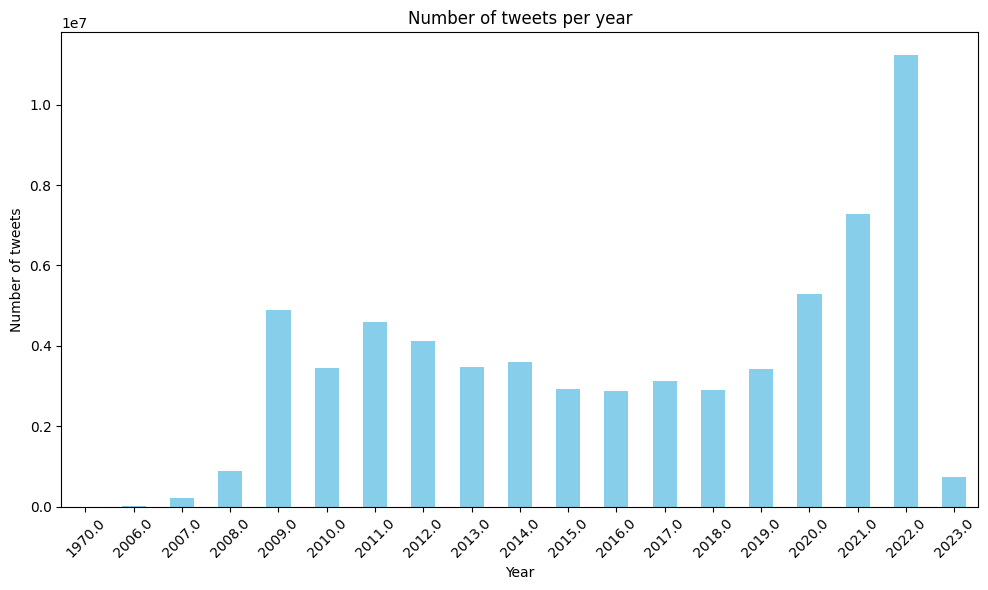

In [16]:
df['year'] = df['usercreatedts'].dt.year
post_counts_by_year = df['year'].value_counts().compute().sort_index()

plt.figure(figsize=(10, 6))
post_counts_by_year.plot(kind='bar', color='skyblue')
plt.title('Number of tweets per year')
plt.xlabel('Year')
plt.ylabel('Number of tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

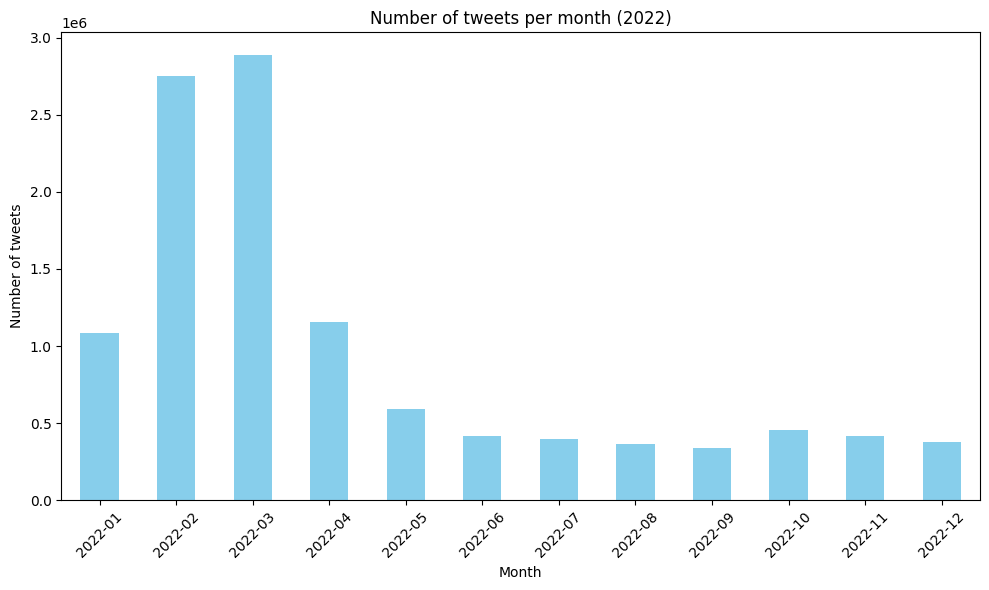

In [17]:
df_dask_2022 = df[df['usercreatedts'].dt.year == 2022]
df_dask_2022['year_month'] = df_dask_2022['usercreatedts'].dt.to_period('M')
post_counts_2022 = df_dask_2022['year_month'].value_counts().compute().sort_index()

plt.figure(figsize=(10, 6))
post_counts_2022.plot(kind='bar', color='skyblue')
plt.title('Number of tweets per month (2022)')
plt.xlabel('Month')
plt.ylabel('Number of tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

AttributeError: This method only works with the ScalarFormatter

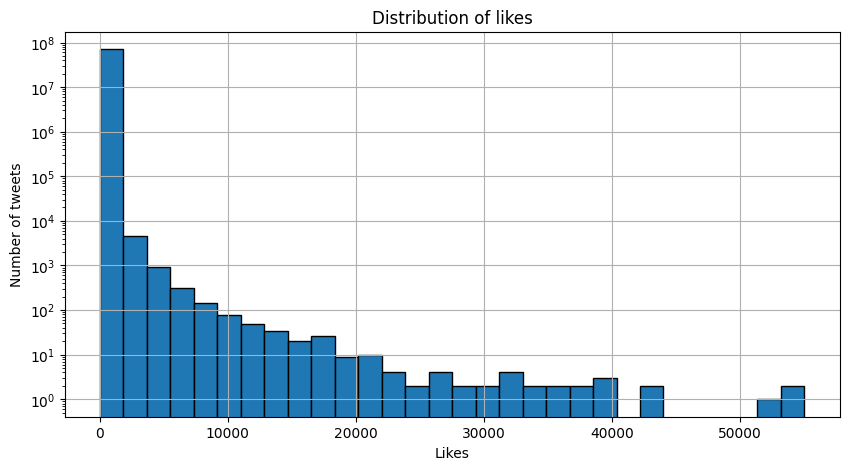

In [44]:
from matplotlib import ticker
likes = pd.read_parquet(file_path, columns=['favorite_count'])
likes = likes[likes["favorite_count"] < 100000]

plt.figure(figsize=(10, 5))
plt.hist(likes["favorite_count"], edgecolor='black', bins=30)
plt.xlabel("Likes")
plt.ylabel("Number of tweets")
plt.title("Distribution of likes")
plt.yscale('log')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
plt.show()

In [45]:
zero_likes = (likes["favorite_count"] == 0).sum()
total = len(likes)

percent_zero_likes = (zero_likes / total) * 100
print(f"Tweets with 0 likes: {zero_likes} ({percent_zero_likes:.2f}%)")

Tweets with 0 likes: 60468095 (85.32%)


In [47]:
df = dd.read_parquet(file_path, columns=['language'])

top_languages = df['language'].value_counts().nlargest(10).compute()

total = df['language'].count().compute()

percentages = (top_languages / total * 100).round(2)

print("Top 10 languages:")
for lang, count in top_languages.items():
    print(f"{lang}: {count} tweets ({percentages[lang]}%)")

Top 10 languages:
en: 44416753 tweets (62.67%)
und: 3898750 tweets (5.5%)
de: 3870981 tweets (5.46%)
fr: 3793946 tweets (5.35%)
it: 3260536 tweets (4.6%)
es: 3112236 tweets (4.39%)
uk: 1541056 tweets (2.17%)
ru: 964561 tweets (1.36%)
tr: 711896 tweets (1.0%)
ja: 688550 tweets (0.97%)


In [48]:
import sys
import os

sys.path.append(os.path.abspath('../src'))

import sentiment

In [49]:
INPUT_PATH = "../parquets/"

dates = ["2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10",
             "2022-11", "2022-12", "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06"]

result = {}
result_pl = {}

rus_neg_monthly_percs = []
ukr_neg_monthly_percs = []

rus_neg_monthly_percs_pl = []
ukr_neg_monthly_percs_pl = []

for date in dates:
    df = pd.read_parquet(INPUT_PATH + "/general/tweet_sentiments_" + date + ".parquet")
    df_pl = pd.read_parquet(INPUT_PATH + "/polish/tweet_sentiments_pl_" + date + ".parquet")

    result = sentiment.get_rus_ukr_percentages(df)
    result_pl = sentiment.get_rus_ukr_percentages(df_pl)
    
    rus_neg_monthly_percs.append(result['rus_neg_perc'])
    ukr_neg_monthly_percs.append(result['ukr_neg_perc'])

    rus_neg_monthly_percs_pl.append(result_pl['rus_neg_perc'])
    ukr_neg_monthly_percs_pl.append(result_pl['ukr_neg_perc'])

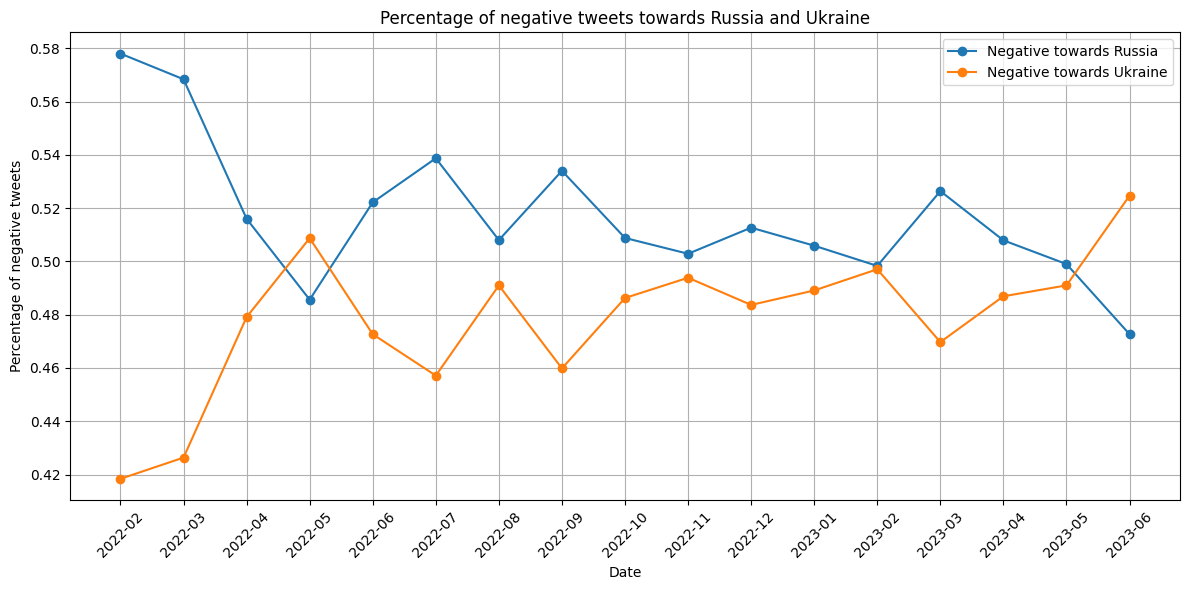

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(dates, rus_neg_monthly_percs, marker='o', label='Negative towards Russia')
plt.plot(dates, ukr_neg_monthly_percs, marker='o', label='Negative towards Ukraine')

plt.title("Percentage of negative tweets towards Russia and Ukraine")
plt.xlabel("Date")
plt.ylabel("Percentage of negative tweets")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Kvba\AppData\Local\Temp\ipykernel_3952\2323363848.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(dates, rotation=45)
C:\Users\Kvba\AppData\Local\Temp\ipykernel_3952\2323363848.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(dates, rotation=45)


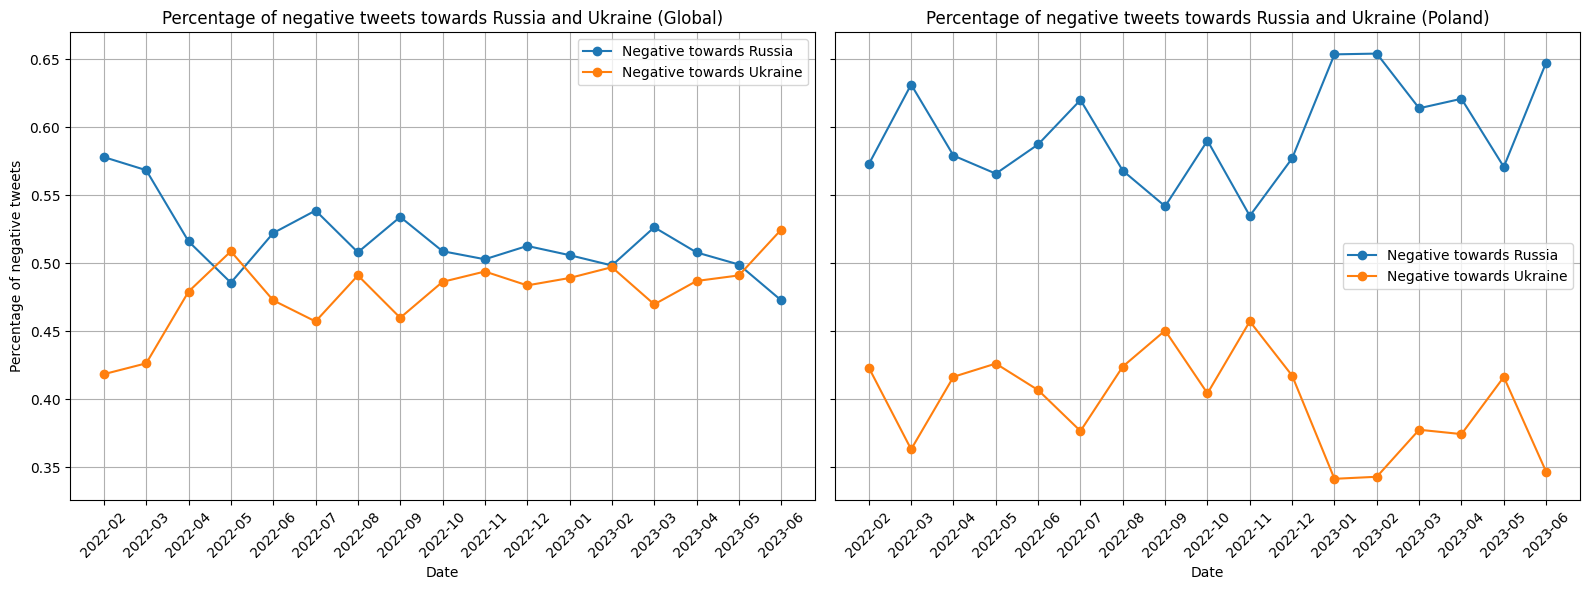

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax1.plot(dates, rus_neg_monthly_percs, marker='o', label='Negative towards Russia')
ax1.plot(dates, ukr_neg_monthly_percs, marker='o', label='Negative towards Ukraine')
ax1.set_title("Percentage of negative tweets towards Russia and Ukraine (Global)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Percentage of negative tweets")
ax1.grid(True)
ax1.legend()
ax1.set_xticklabels(dates, rotation=45)


ax2.plot(dates, rus_neg_monthly_percs_pl, marker='o', label='Negative towards Russia')
ax2.plot(dates, ukr_neg_monthly_percs_pl, marker='o', label='Negative towards Ukraine')
ax2.set_title("Percentage of negative tweets towards Russia and Ukraine (Poland)")
ax2.set_xlabel("Date")
ax1.set_ylabel("Percentage of negative tweets")
ax2.grid(True)
ax2.legend()
ax2.set_xticklabels(dates, rotation=45)

plt.tight_layout()
plt.show()

In [53]:
from collections import Counter

general_path = INPUT_PATH + "general"

all_files = [os.path.join(general_path, f) for f in os.listdir(general_path) if f.endswith(".parquet")]

dfs = [pd.read_parquet(f) for f in all_files]
combined_general_df = pd.concat(dfs, ignore_index=True)
df_rus, df_ukr = sentiment.get_rus_ukr_parts(combined_general_df)

all_hashtags = df_rus["hashtags"].explode()
hashtag_counts = Counter(all_hashtags.dropna())
hash_top10_rus = hashtag_counts.most_common(10)

all_hashtags = df_ukr["hashtags"].explode()
hashtag_counts = Counter(all_hashtags.dropna())
hash_top10_ukr = hashtag_counts.most_common(10)

print("Top 10 hashtags for tweets negative towards Russia:")
for tag, count in hash_top10_rus:
    print(f"{tag}: {count}")
    
print("Top 10 hashtags for tweets negative towards Ukraine:")
for tag, count in hash_top10_ukr:
    print(f"{tag}: {count}")

Top 10 hashtags for tweets negative towards Russia:
Ukraine: 18713
Russia: 9176
StandWithUkraine: 4621
Putin: 4347
UkraineRussiaWar: 3992
RussiaIsATerroristState: 2682
Bakhmut: 2653
Germany: 2558
UkraineWar: 2094
Russian: 2067
Top 10 hashtags for tweets negative towards Ukraine:
Ukraine: 14711
Russia: 5440
Putin: 2851
Bakhmut: 1933
NATO: 1784
Canada: 1738
Zelensky: 1671
USA: 1644
Germany: 1625
UkraineRussiaWar: 1608


C:\Users\Kvba\AppData\Local\Temp\ipykernel_3952\1607527158.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rus_tags, rotation=45, ha='right')
C:\Users\Kvba\AppData\Local\Temp\ipykernel_3952\1607527158.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ukr_tags, rotation=45, ha='right')


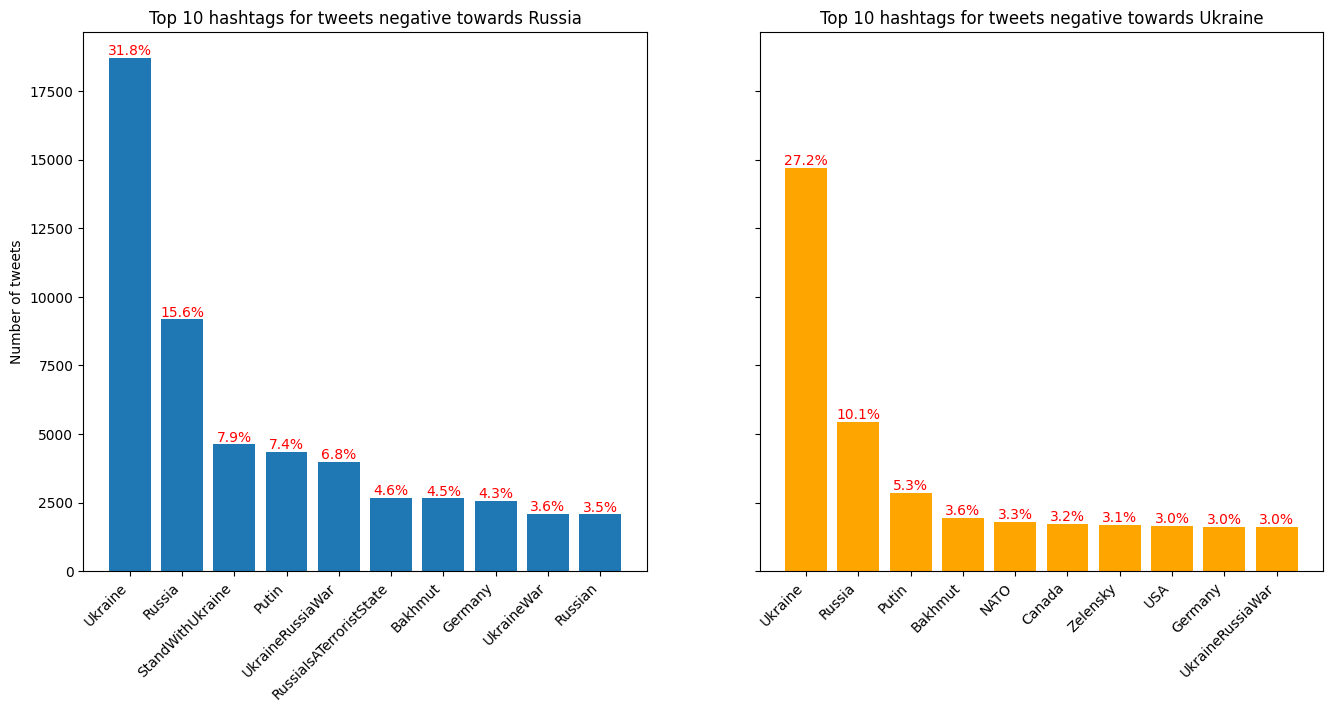

In [55]:
rus_tags, rus_counts = zip(*hash_top10_rus)
ukr_tags, ukr_counts = zip(*hash_top10_ukr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7), sharey=True)

rus_percents = [count / len(df_rus) for count in rus_counts]
bars1 = ax1.bar(rus_tags, rus_counts)
for i, (bar, perc) in enumerate(zip(bars1, rus_percents)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f"{perc:.1%}", ha='center', va='bottom', fontsize=10, color='red')
ax1.set_title("Top 10 hashtags for tweets negative towards Russia")
ax1.set_xticklabels(rus_tags, rotation=45, ha='right')
ax1.set_ylabel("Number of tweets")

ukr_percents = [count / len(df_ukr) for count in ukr_counts]
bars2 = ax2.bar(ukr_tags, ukr_counts, color='orange')
for i, (bar, perc) in enumerate(zip(bars2, ukr_percents)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height, f"{perc:.1%}", ha='center', va='bottom', fontsize=10, color='red')
ax2.set_title("Top 10 hashtags for tweets negative towards Ukraine")
ax2.set_xticklabels(ukr_tags, rotation=45, ha='right')

plt.show()

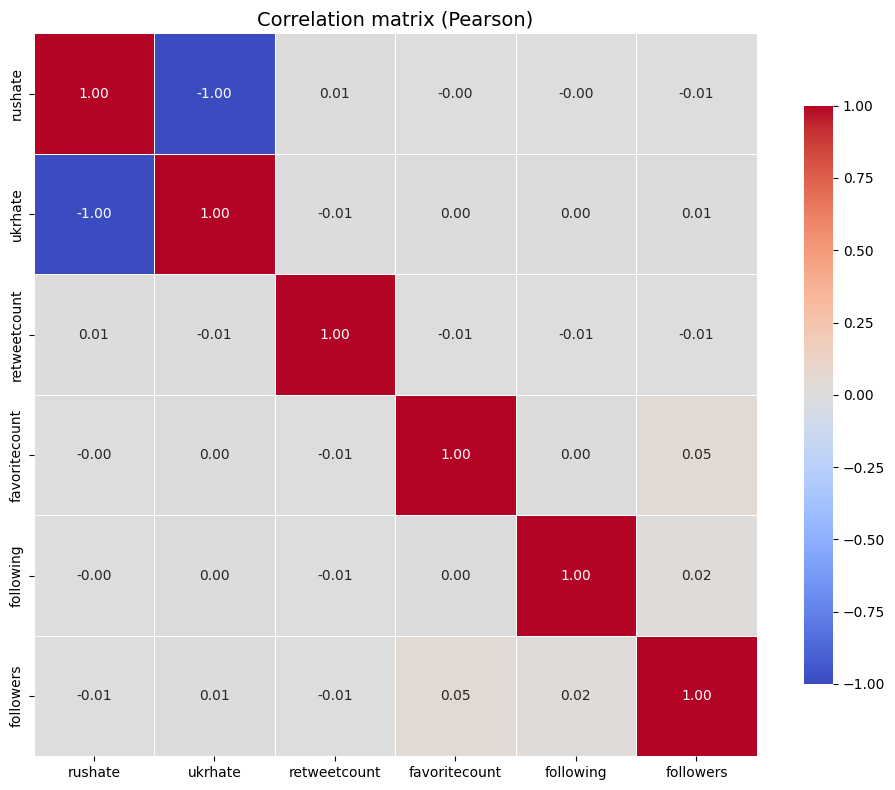

In [57]:
import seaborn as sns

cols = ["rushate", "ukrhate", "retweetcount", "favoritecount", "following", "followers"]

corr = combined_general_df[cols].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation matrix (Pearson)", fontsize=14)
plt.tight_layout()
plt.show()

## Libraries and their performance

### Finding min-max in column

In [73]:
file_path = "../ukr_rus_tweets.parquet"

start_pandas = time.time()

table = pq.read_table(file_path, columns=['usercreatedts'])
df_pandas = table.to_pandas()
df_pandas['usercreatedts'] = pd.to_datetime(df_pandas['usercreatedts'], errors='coerce')
min_date_pandas = df_pandas['usercreatedts'].min()
max_date_pandas = df_pandas['usercreatedts'].max()

end_pandas = time.time()
print(f"[PANDAS] Execution time: {end_pandas - start_pandas:.2f} seconds\n")

MemoryError: Unable to allocate 541. MiB for an array with shape (70876102,) and data type object

In [72]:
start_dask = time.time()

df_dask = dd.read_parquet(file_path, columns=['usercreatedts'])
df_dask['usercreatedts'] = dd.to_datetime(df_dask['usercreatedts'], errors='coerce')
min_date_dask = df_dask['usercreatedts'].min().compute()
max_date_dask = df_dask['usercreatedts'].max().compute()

end_dask = time.time()
print(f"[DASK] Execution time: {end_dask - start_dask:.2f} seconds\n")

[DASK] Execution time: 38.14 seconds


In [64]:
import duckdb


con = duckdb.connect()
query = f"""
    SELECT 
        MIN(CAST(usercreatedts AS TIMESTAMP)) AS min_date, 
        MAX(CAST(usercreatedts AS TIMESTAMP)) AS max_date 
    FROM read_parquet('{file_path}')
"""
start_duck = time.time()

min_date_duck, max_date_duck = con.execute(query).fetchone()

end_duck = time.time()
print(f"[DUCKDB] Execution time: {end_duck - start_duck:.2f} seconds\n")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[DUCKDB] Execution time: 2.51 seconds


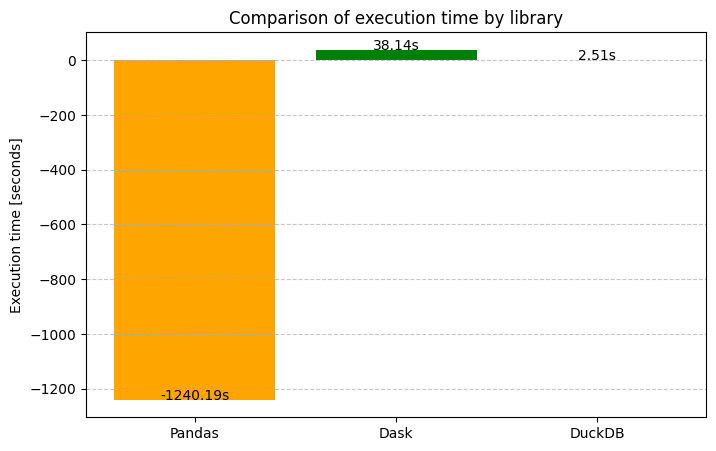

In [75]:
times = {}
times['Pandas'] = end_pandas - start_pandas
times['Dask'] = end_dask - start_dask
times['DuckDB'] = end_duck - start_duck

plt.figure(figsize=(8, 5))
plt.bar(times.keys(), times.values(), color=['orange', 'green', 'red'])
plt.ylabel("Execution time [seconds]")
plt.title("Comparison of execution time by library")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(times.values()):
    plt.text(i, v + 0.02, f"{v:.2f}s", ha='center', fontsize=10)
plt.show()